In [1]:
import numpy as np
import pandas as pd
import os
import gym
import random
from gym import spaces
import torch
import matplotlib.pyplot as plt
from Environment import DiagnosisEnv
from Agent import train_DQN

In [2]:
df_symptoms = pd.read_csv("Data/Symptoms.csv")
df_exams = pd.read_csv("Data/Examinations.csv")
df_gen_surgery_diagnoses = pd.read_csv("Data/Gen_Surgery_Diagnosis.csv")

In [3]:
env = DiagnosisEnv(df_symptoms, df_exams, df_gen_surgery_diagnoses)
agent, rewards, success_rates, examinations_per_diagnosis = train_DQN(env, episodes=2000)

C:\Users\jerem\Project_Hospital\Agent.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return (torch.tensor(state, dtype=torch.float32),


In [4]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

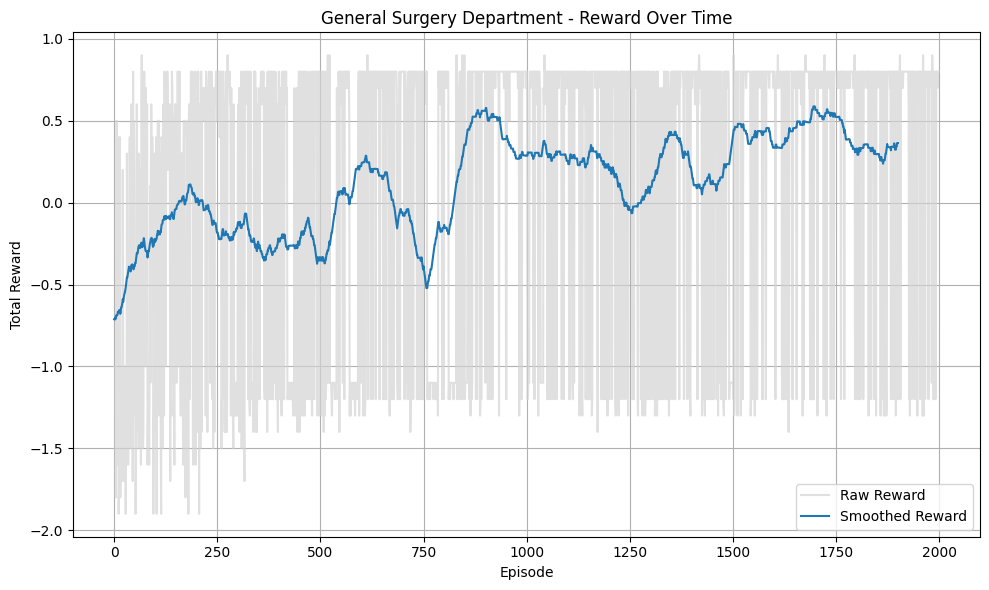

In [5]:
smoothed_rewards = moving_average(rewards, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(rewards, color="lightgray", label="Raw Reward", alpha=0.7)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("General Surgery Department - Reward Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

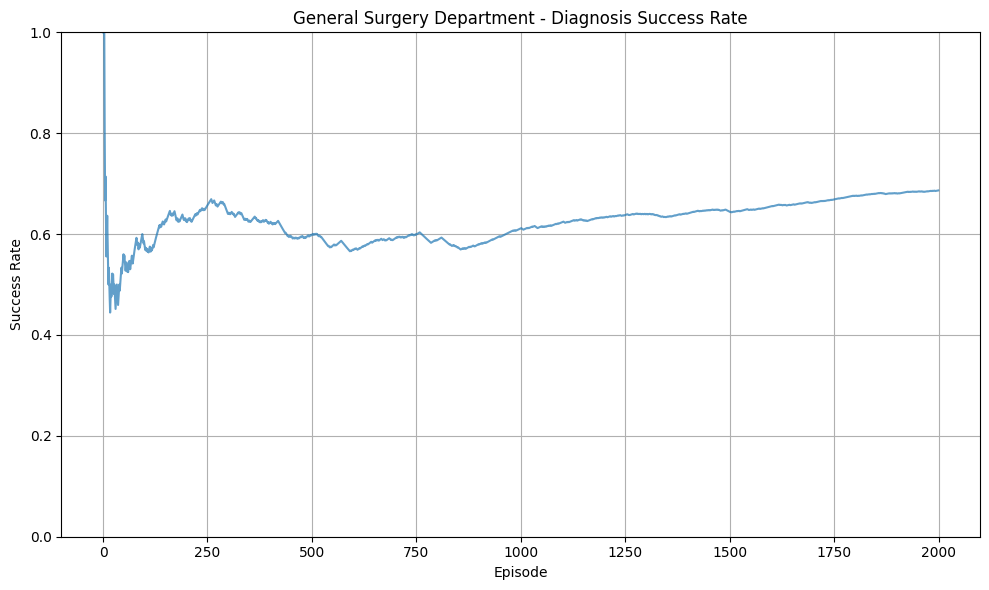

In [6]:
plt.figure(figsize=(10,6))
plt.plot(success_rates, alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("General Surgery Department - Diagnosis Success Rate")
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()

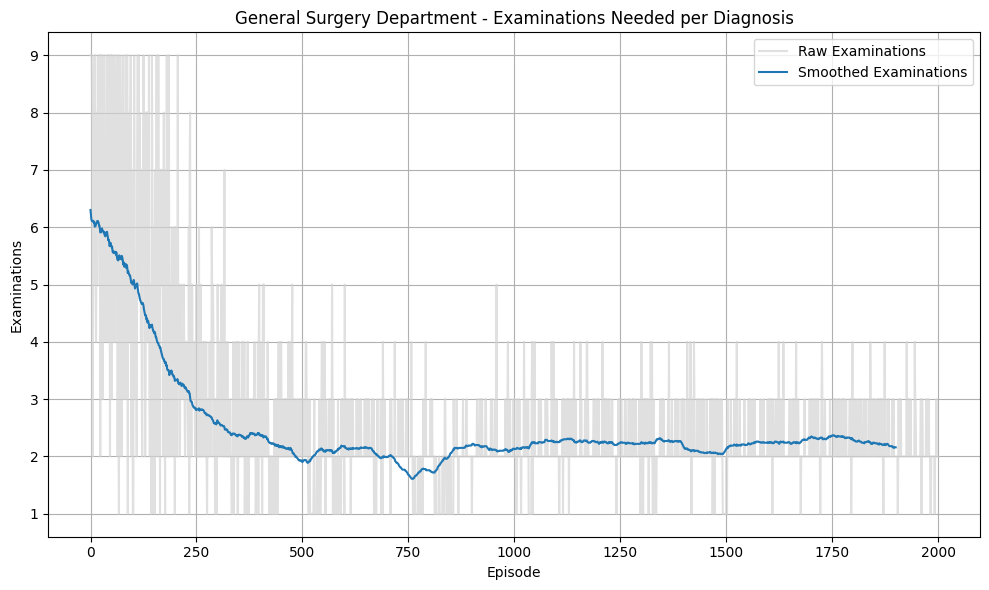

In [7]:
smoothed_examinations = moving_average(examinations_per_diagnosis, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(examinations_per_diagnosis, color="lightgray", label="Raw Examinations", alpha=0.7)
plt.plot(range(len(smoothed_examinations)), smoothed_examinations, label="Smoothed Examinations")
plt.xlabel("Episode")
plt.ylabel("Examinations")
plt.title("General Surgery Department - Examinations Needed per Diagnosis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
def test_agent(env, agent, num_patients=10):
    number_of_diagnoses = len(df_gen_surgery_diagnoses)
    print("General Surgery Department, Number of possible Diagnosis: " + str(number_of_diagnoses))
    overall_correct_diagnoses = 0
    for num in range(number_of_diagnoses):
        correct_diagnoses = 0
        for patient_num in range(num_patients):
            state = env.set(num)
    
            exams_taken = []
            symptoms_history = []
    
            done = False
            step_count = 0
    
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent(state_tensor).squeeze()
                action = q_values.argmax().item()
                exam_taken = env.examinations[action]
    
                state, reward, done, info = env.step(action)
                observed_symptoms = env.get_observed_symptoms()
    
                exams_taken.append(exam_taken)
                symptoms_history.append(observed_symptoms)
    
                if info.get("forced", False):
                    if info["guess"] == info["diagnosis"]:
                        correct_diagnoses += 1
                        overall_correct_diagnoses += 1
                    break
    
                step_count += 1
    
        accuracy = correct_diagnoses / num_patients
        print(df_gen_surgery_diagnoses.loc[num,'Diagnosis'].capitalize() + " - Accuracy over " + str(num_patients) + " patients: " + str(accuracy))
    print("General Surgery Department - Overall Accuracy: " + str(round(overall_correct_diagnoses / (num_patients * number_of_diagnoses) * 100,2)) + "%")

In [9]:
test_agent(env, agent, num_patients=10)

General Surgery Department, Number of possible Diagnosis: 46
Acute renal failure - Accuracy over 10 patients: 1.0
Appendicitis - Accuracy over 10 patients: 1.0
Bacterial gastroenteritis - Accuracy over 10 patients: 0.9
Blunt pancreas laceration - Accuracy over 10 patients: 1.0
Blunt spleen rupture - Accuracy over 10 patients: 1.0
Calculus in bladder - Accuracy over 10 patients: 1.0
Calculus of ureter - Accuracy over 10 patients: 0.4
Campylobacteriosis - Accuracy over 10 patients: 1.0
Cholangitis - Accuracy over 10 patients: 1.0
Cholecystitis - Accuracy over 10 patients: 0.7
Chronic kidney disease - Accuracy over 10 patients: 1.0
Cirrhosis - Accuracy over 10 patients: 0.9
Coeliac disease - Accuracy over 10 patients: 1.0
Crohn's disease - Accuracy over 10 patients: 1.0
Duodenitis - Accuracy over 10 patients: 0.7
Esophageal varices - Accuracy over 10 patients: 0.4
Esophagitis - Accuracy over 10 patients: 0.9
Exocrine pancreatic insufficiency - Accuracy over 10 patients: 0.5
Fistula of the

In [10]:
def test_diagnosis(env, agent, diagnosis, num_patients=5):
    int_diagnosis = int(df_gen_surgery_diagnoses.index[df_gen_surgery_diagnoses["Diagnosis"] == diagnosis].tolist()[0])
    correct_diagnoses = 0
    for patient_num in range(num_patients):
        state = env.set(int_diagnosis)

        print("\nPATIENT " + str(patient_num + 1))
        print("TRUE DIAGNOSIS: " + str(env.get_true_diagnosis()))
        print("TRUE SYMPTOMS (Generated for this patient): " + str(env.get_true_symptoms()) + "\n")

        exams_taken = []
        symptoms_history = []

        done = False
        step_count = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor).squeeze()
            action = q_values.argmax().item()
            exam_taken = env.examinations[action]

            state, reward, done, info = env.step(action)
            observed_symptoms = env.get_observed_symptoms()

            exams_taken.append(exam_taken)
            symptoms_history.append(observed_symptoms)

            if info.get("forced", False):
                print(f"\nGuessed Diagnosis: {info['guess'].capitalize()}")
                if info["guess"] == info["diagnosis"]:
                    correct_diagnoses += 1
                break
                
            print("Step " + str(step_count + 1))
            print("Examination taken: " + str(exam_taken))
            print("Symptoms uncovered so far: " + str(observed_symptoms))

            step_count += 1
    
    accuracy = correct_diagnoses / num_patients
    print(f"{diagnosis.capitalize()}: Accuracy over {num_patients} patients: {accuracy:.2f}")

In [11]:
test_diagnosis(env, agent, "esophageal varices", 5)


PATIENT 1
TRUE DIAGNOSIS: esophageal varices
TRUE SYMPTOMS (Generated for this patient): ['hematochezia', 'oesophagus abnormalities', 'portal hypertension', 'vomiting', 'varices in the oesophagus']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['vomiting']
Step 2
Examination taken: neurological testing
Symptoms uncovered so far: ['vomiting']

Guessed Diagnosis: Acute renal failure

PATIENT 2
TRUE DIAGNOSIS: esophageal varices
TRUE SYMPTOMS (Generated for this patient): ['hematochezia', 'jaundice', 'portal hypertension', 'varices in the oesophagus']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['jaundice']
Step 2
Examination taken: urine sample analysis testing
Symptoms uncovered so far: ['jaundice']

Guessed Diagnosis: Cholangitis

PATIENT 3
TRUE DIAGNOSIS: esophageal varices
TRUE SYMPTOMS (Generated for this patient): ['oesophagus abnormalities', 'vomiting', 'varices in the oesophagus']

Step 1
Examination taken: interview
Symptoms uncovered so fa

In [12]:
test_diagnosis(env, agent, "fistula of the intestine", 5)


PATIENT 1
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['abdominal pain', 'bloating', 'dehydration', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal pain', 'bloating']
Step 2
Examination taken: blood test testing
Symptoms uncovered so far: ['abdominal pain', 'bloating']

Guessed Diagnosis: Crohn's disease

PATIENT 2
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['abdominal pain', 'bloating', 'dehydration', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal pain', 'bloating']
Step 2
Examination taken: blood test testing
Symptoms uncovered so far: ['abdominal pain', 'bloating']

Guessed Diagnosis: Crohn's disease

PATIENT 3
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['bloating', 'dehydration', 'diarrhea', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms 

In [16]:
test_diagnosis(env, agent, "pancreas contusion", 5)


PATIENT 1
TRUE DIAGNOSIS: pancreas contusion
TRUE SYMPTOMS (Generated for this patient): ['abdominal injury', 'abdominal pain', 'blunt pancreas contusion']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal injury', 'abdominal pain']
Step 2
Examination taken: x ray upper limb
Symptoms uncovered so far: ['abdominal injury', 'abdominal pain']

Guessed Diagnosis: Blunt pancreas laceration

PATIENT 2
TRUE DIAGNOSIS: pancreas contusion
TRUE SYMPTOMS (Generated for this patient): ['abdominal injury', 'abdominal pain', 'blunt pancreas contusion']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal injury', 'abdominal pain']
Step 2
Examination taken: x ray upper limb
Symptoms uncovered so far: ['abdominal injury', 'abdominal pain']

Guessed Diagnosis: Blunt pancreas laceration

PATIENT 3
TRUE DIAGNOSIS: pancreas contusion
TRUE SYMPTOMS (Generated for this patient): ['abdominal injury', 'bruise', 'blunt pancreas contusion']

Step 1
Examination t